#  Masking Pipeline


"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [4]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [5]:
hdr = db[{{ uid }}]

NameError: name 'uid' is not defined

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

%matplotlib notebook

## Lazy Eiger Handler (later will goto databroker)¶

In [10]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'pixel_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            md = {k: f[v].value for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        pixel_mask = md['pixel_mask']
        pixel_mask[pixel_mask>0] = 1
        pixel_mask[pixel_mask==0] = 2
        pixel_mask[pixel_mask==1] = 0
        pixel_mask[pixel_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

In [11]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("    %s: %s" % (key, val))


In [12]:
uid = '528bd8'

hdr = db[uid]

## Get the data from the uid or scan id

In [13]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'])

hdf5 path = /XF11ID/data/2015/11/5/794b68e2-ebc7-4aa8-a3e4_422_master.h5


In [14]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/11/5/'

In [15]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 1 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


## show the pixel mask

<IPython.core.display.Javascript object>


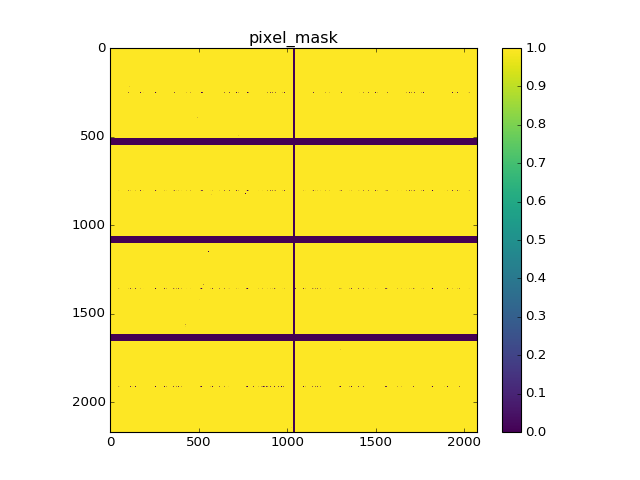

In [16]:
fig, ax = plt.subplots()
im = ax.imshow(imgs.md['pixel_mask'], vmin=0,vmax=1,cmap='viridis')
ax.set_title( 'pixel_mask')
fig.colorbar( im )
plt.show()

## Import all the required packages to create manual mask
xray-vision - plotting helper functions for X-ray science
https://github.com/Nikea/xray-vision

In [18]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mpl_plotting import speckle
from xray_vision.mask.manual_mask import ManualMask

## Remove hotspots in the image

In [19]:
class RemoveHotSpots(object):
    def __init__(self, indexable, threshold= 1E7 ):
        self.indexable = indexable
        self.threshold = threshold
        self.N = len( indexable  ) 
    def _get_mask(self ):
        mask = np.ones_like( np.array( self.indexable[0])    )
        for key in range(self.N):
            data = np.array( self.indexable[key])  #.copy()        
            badp = np.where(  data >= self.threshold )
            if len(badp[0])!=0:                
                mask[badp] = 0                            
        return mask

### Enter the therdshold to remove the hotspots

In [20]:
mask_rh  = RemoveHotSpots(imgs, 5E4)._get_mask()

In [21]:
mask_rh.shape

(2167, 2070)

## Get the Averaged Image Data

In [22]:
avg_img = np.average(imgs[::50], axis=0) *imgs.md['pixel_mask']*mask_rh

In [23]:
avg_img.shape

(2167, 2070)

<IPython.core.display.Javascript object>


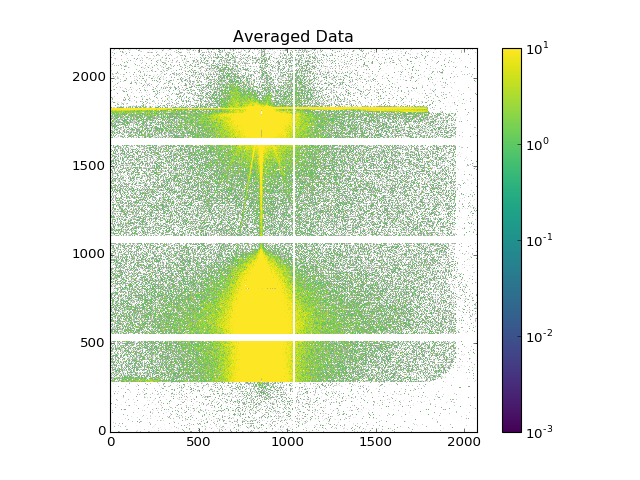

In [24]:
# Plot the result
fig, ax = plt.subplots()
im = ax.imshow(avg_img,  cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e1 ) )

fig.colorbar(im)
ax.set_title("Averaged Data")
plt.show()

## Create the mask file
More information : https://github.com/Nikea/xray-vision/blob/master/xray_vision/mask/manual_mask.py

In [25]:
fig, ax = plt.subplots()
m = ManualMask(ax, avg_img*imgs.md['pixel_mask']*mask_rh,
               cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e3 ) )
#press o to quit zoom mode

plt.show()

<IPython.core.display.Javascript object>

In [26]:
new_mask = m.mask
fig, ax = plt.subplots()
im=ax.imshow(~new_mask, origin='lower', vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>

In [64]:
np.where( m.label_array ==5)

(array([581, 582, 582, ..., 750, 750, 750]),
 array([ 989,  988,  989, ..., 1006, 1007, 1008]))

In [59]:
m.mask

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

In [62]:
np.unique( m.label_array)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [86]:
x = np.zeros_like( m.label_array)

In [89]:
x[ np.where( m.label_array == 5) ] =5

<IPython.core.display.Javascript object>


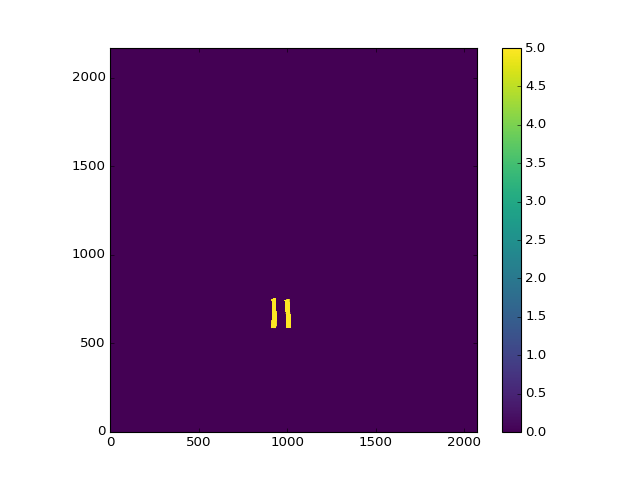

In [90]:
new_mask =  x
fig, ax = plt.subplots()
im=ax.imshow(new_mask, origin='lower', vmin=0, vmax=5,cmap='viridis')
fig.colorbar(im)
plt.show()

In [ ]:
ig = np.random( 100,150)
fig, ax = plt.subplots()
m = ManualMask(ax, ig,
               cmap='viridis',origin='lower',
               norm= LogNorm( vmin=0.001, vmax=1e1 ) )
plt.show()

## Combine the hand-drawn mask and the pixel mask and hot pixel mask

In [ ]:
mask = (~new_mask)*imgs.md['pixel_mask']*mask_rh

fig, ax = plt.subplots()
im = ax.imshow(mask, origin='lower', vmin=0, vmax=1, cmap='viridis')
fig.colorbar(im)
plt.show()

## save the combined mask to use in data analysis

In [ ]:
np.save(path +  str(uid)+"_mask", mask)